# Rubin baseline_v2.0 visibility and visits

In [1]:
from os import path
import rubin_sim.maf as maf
from rubin_sim.data import get_data_dir
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u
from astropy.io import fits

Firstly, we extract the number of visits made by Rubin over 10yrs (including all filters) from the baseline_v2.0 OpSim database, by calculating the Nvis metric.

In [2]:
opsim_db_file = '/Users/rstreet1/rubin_sim_data/sim_baseline/baseline_v2.0_10yrs.db'
opsim_db = maf.OpsimDatabase(opsim_db_file)
runName = path.split(opsim_db_file)[-1].replace('.db', '')

In [3]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)

bundleList = []
metric1 = maf.metrics.CountMetric(col=['night'], metricName='Nvis')
constraint = 'fiveSigmaDepth > 21.5'
slicer = maf.slicers.HealpixSlicer(nside=NSIDE, useCache=False)
plotDict = {'colorMax': 950}
bundleList.append(maf.MetricBundle(metric1, slicer, constraint, runName=runName, plotDict=plotDict))
bundleDict = maf.metricBundles.makeBundlesDictFromList(bundleList)
bundleGroup = maf.MetricBundleGroup(bundleDict, opsim_db, outDir='test', resultsDb=None)
bundleGroup.runAll()


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying table None with constraint fiveSigmaDepth > 21.5 for columns ['fieldRA', 'fieldDec', 'night', 'rotSkyPos']
Found 2040356 visits
Running:  ['baseline_v2_0_10yrs_Nvis_fiveSigmaDepth_gt_21_5_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


0.0 180.0 -180.0 180.0
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_4766/416416312.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


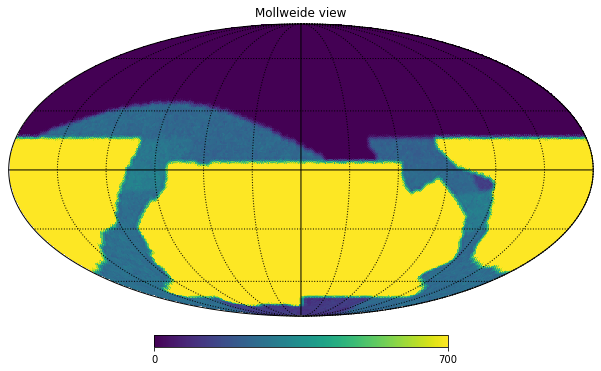

In [4]:
outputName = 'baseline_v2_0_10yrs_Nvis_fiveSigmaDepth_gt_21_5_HEAL'
metricData = bundleDict[outputName].metricValues.filled(0.0)
fig = plt.figure(1,(10,10))
hp.mollview(metricData, min=0, max=700)
hp.graticule()
plt.tight_layout()
plt.close(1)

## Rubin Visibility Zone

We can infer those regions of the sky within the Rubin visibility limits from the number of visits per pointing returned from this metric.

In [5]:
mask = bundleDict[runName.replace('.','_')+\
                '_Nvis_fiveSigmaDepth_gt_21_5_HEAL'].metricValues.mask
rubin_visibility_zone = np.where(mask == False)[0]

rubin_visibility_map = np.zeros(NPIX)
rubin_visibility_map[rubin_visibility_zone] = 1.0

0.0 180.0 -180.0 180.0
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_4766/3648820171.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


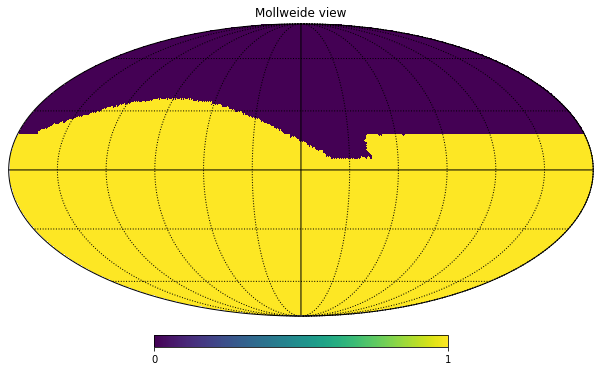

In [6]:
fig = plt.figure(2,(10,10))
hp.mollview(rubin_visibility_map)
hp.graticule()
plt.tight_layout()
#plt.savefig(file_name)
plt.close(2)

## Sky Region in the Galactic Plane

Baseline_v2.0 included a region in the central Galactic Plane dubbed "the Diamond".  Here we calculate a rough estimate of the total number of square degrees included in this region. 

Firstly, we calculate the sky coordinates for the centre of each HEALpixel

In [7]:
outputName = 'baseline_v2_0_10yrs_Nvis_fiveSigmaDepth_gt_21_5_HEAL'
metricData = bundleDict[outputName].metricValues.filled(0.0)

pixelPositions = []
(theta, phi) = hp.pix2ang(NSIDE,range(0,len(metricData),1))

ra = np.rad2deg(phi)
dec = np.rad2deg((np.pi/2.0) - theta)

skyPositions = SkyCoord(ra*u.deg,
                        dec*u.deg,
                        frame='icrs')
print(skyPositions.ra)
galPositions = skyPositions.transform_to(Galactic)
print(galPositions)

[45d00m00s 135d00m00s 225d00m00s ... 135d00m00s 225d00m00s 315d00m00s]
<SkyCoord (Galactic): (l, b) in deg
    [(123.36647898,  26.50863827), (123.6298103 ,  27.51540064),
     (122.49253442,  27.74651416), ..., (302.23887681, -26.7376784 ),
     (303.36647898, -26.50863827), (303.6298103 , -27.51540064)]>


We can now use these positions to identify those HEALpixels within the Galactic Plane.

0.0 180.0 -180.0 180.0
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_4766/3425622070.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


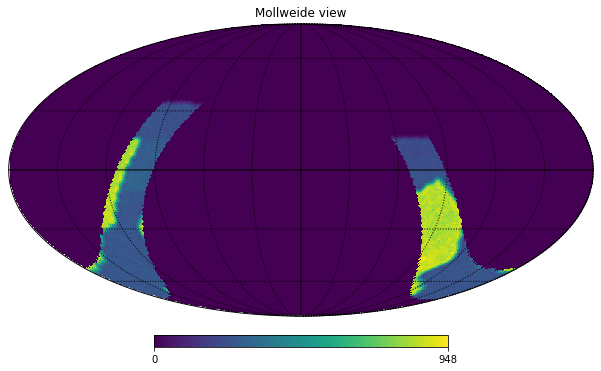

In [11]:
mask = abs(galPositions.b.deg) < 10.0
galPlaneData = np.zeros(NPIX)
galPlaneData[mask] = metricData[mask]

fig = plt.figure(3,(10,10))
hp.mollview(galPlaneData)
hp.graticule()
plt.tight_layout()
#plt.savefig(file_name)
plt.close(3)

However, this includes large regions where the number of visits is still very low, so we exclude these with a cut on the number of visits per pointing over 10yrs.

0.0 180.0 -180.0 180.0
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_4766/637381144.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


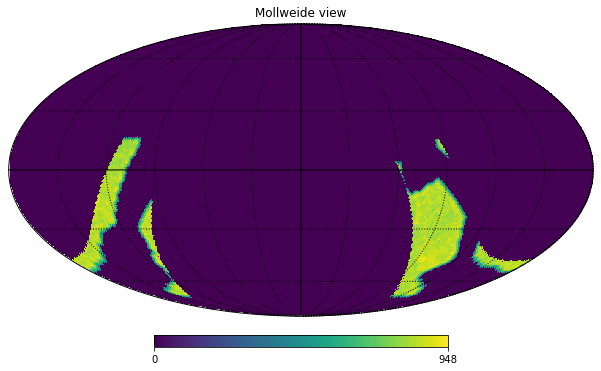

In [9]:
mask2 = galPlaneData > 400
galPlaneRegion = np.zeros(NPIX)
galPlaneRegion[mask2] = metricData[mask2]

fig = plt.figure(4,(10,10))
hp.mollview(galPlaneRegion)
hp.graticule()
plt.tight_layout()
#plt.savefig(file_name)
plt.close(4)

Now we can use the selected HEALpixels to estimate the total area in the Galactic Plane visited more than a "background" number of times. 

In [10]:
pix_area = hp.nside2pixarea(NSIDE,degrees=True)
pix_index = np.where(mask2)[0]
region_area = len(pix_index) * pix_area
print('Total area surveyed in the Galactic Plane: '+str(round(region_area,2))+' sq deg')

Total area surveyed in the Galactic Plane: 2797.37 sq deg


In [22]:
from rubin_sim.scheduler.utils import Sky_area_generator

nside = 64

# Sky_area_generator - from rubin_sim/scheduler/utils
sky = Sky_area_generator(nside=nside)
maps, labels = sky.return_maps()

wfd_indx = np.where(labels == 'lowdust')[0]
bulge_idx = np.where(labels == 'bulge')[0]
mcs_idx = np.where(labels == 'LMC_SMC')[0]

area = (len(bulge_idx)+len(mcs_idx)) * hp.nside2pixarea(nside, degrees=True)
print(area)
not_wfd_idx = np.where(labels != 'lowdust')[0]

1375.6022845011023


0.0 180.0 -180.0 180.0
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_4766/1625264821.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


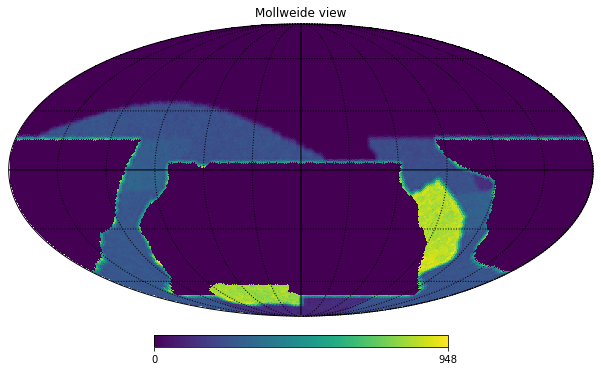

In [17]:
region = np.zeros(NPIX)
region[not_wfd_idx] = metricData[not_wfd_idx]

fig = plt.figure(4,(10,10))
hp.mollview(region)
hp.graticule()
plt.tight_layout()
#plt.savefig(file_name)
plt.close(4)

In [18]:
labels

array(['', '', '', ..., 'scp', 'scp', 'scp'], dtype='<U20')

In [19]:
np.unique(labels)

array(['', 'LMC_SMC', 'bulge', 'dusty_plane', 'lowdust', 'nes', 'scp',
       'virgo'], dtype='<U20')